In [1]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg


In [2]:
import os
os.chdir('..')

# Preparing product attr

In [3]:
import pandas as pd

In [4]:
csv = 'datasets/OCR/label_text_product_attrs.csv'

In [5]:
df = pd.read_csv(csv)

In [6]:
df

,image_name,text,sku,product_name,quantity,sale_price,final_price,discounted_part,original_price
0,img_1_padded_0.jpg,04902430779746 NX DOWNY doahoa ngotngao\nVAT10...,4902430779746,NX DOWNY doahoa ngotngao,1,"88,000.00","88,000.00",NaN,"103,000.00"
1,img_2_padded_0.jpg,04902430418287 NX DOWNY doahoa ngotngao\nVAT10...,4902430418287,NX DOWNY doahoa ngotngao,1,"129,900.00","129,900.00",NaN,"159,000.00"
2,img_2_padded_1.jpg,00075069154087 Thit hop Bris.Chop.Ham ck\nVAT1...,75069154087,Thit hop Bris.Chop.Ham ck,1,"98,900.00","98,900.00",NaN,NaN
3,img_2_padded_2.jpg,"00000002952467 Thit xay kg-NCC\nVAT10% 132,...",2952467,Thit xay kg-NCC,0.070 KG,"132,000.00","9,240.00",NaN,NaN
4,img_2_padded_3.jpg,"00000002950055 Cai bo xoi Kg\nVAT10% 35,000...",2950055,Cai bo xoi Kg,0.278 KG,"35,000.00","9,730.00",NaN,NaN
...,...,...,...,...,...,...,...,...,...
328,img_157_padded_13.jpg,"00000002950190 Gia song Kg\nVAT10% 13,000....",2950190,Gia song Kg,0.310 KG,"13,000.00","4,030.00",NaN,NaN
329,img_160_padded_0.jpg,08934868150787 NG Surf huong choadkytui \nVAT...,8934868150787,NG Surf huong choadkytui,1,"79,000.00","79,000.00",NaN,"114,000.00"
330,img_160_padded_1.jpg,04902430877275 NX DOWNY phoi trong nha T\nVAT...,4902430877275,NX DOWNY phoi trong nha T,1,"129,900.00","129,900.00",NaN,"159,000.00"
331,img_160_padded_2.jpg,08934868150756 NG Surf huongsmaidmat tui\nVAT...,8934868150756,NG Surf huongsmaidmat tui,1,"79,000.00","79,000.00",NaN,"114,000.00"


In [7]:
# with open('datasets/OCR/ground_truth.txt', 'r') as f:
#     lines = f.readlines()
#     annotations = [l.strip().split(' ', 1) for l in lines]


In [8]:
dataset = 'datasets/OCR/images'
txt_files = [os.path.join(dataset, file) for file in os.listdir(dataset) if file.endswith('.txt')]

annotations = []

for file in txt_files:
    with open(file, 'rb') as f:
        s = f.read()
        filename = os.path.splitext(os.path.splitext(os.path.split(file)[1])[0])[0]
        annotations.append(['images/' + filename + '.jpg', s.decode('utf-8')])

In [9]:
len(annotations)

440

In [13]:
# if not isinstance(annotations, list):
# annotations = []
for index, row in df.iterrows():
    
    annotation = [os.path.join('label_text_16012020', row['image_name']), row['text']]
    annotations.append(annotation)


In [14]:
len(annotations)

773

In [16]:
annotations[122]

['images/img_141_padded_date_95.jpg', 'Ngay: 9/10/2020']

# Train test split

In [17]:
import random

In [18]:
# gt_items = list(ground_truth.items())
# random.shuffle(gt_items)

random.shuffle(annotations)

In [19]:
train_size = 0.8

train_data = []
test_data = []
for i, (filename, annotation) in enumerate(annotations):
    if i < int(train_size * len(annotations)):
        train_data.append(''.join([filename, '\t', annotation, '\n']))
    else:
        test_data.append(''.join([filename, '\t', annotation, '\n']))


In [20]:
with open('datasets/OCR/train_annotation.txt', 'w') as f:
    for row in train_data:
        f.write(row)
    f.close()

with open('datasets/OCR/test_annotation.txt', 'w') as f:
    for row in test_data:
        f.write(row)
    f.close()

In [7]:
model = 'vgg_seq2seq'
config = Cfg.load_config_from_name(model)


In [8]:
with open('datasets/OCR/train_annotation.txt', 'r') as f:
    lines = f.readlines()
    train_annotations = [l.strip().split('\t') for l in lines]
try:
    for i,( _, _) in enumerate(train_annotations):
        pass
except ValueError:
    print('Error at line:', i)


In [9]:
with open('datasets/OCR/test_annotation.txt', 'r') as f:
    lines = f.readlines()
    test_annotations = [l.strip().split('\t') for l in lines]
try:
    for i,( _, _) in enumerate(test_annotations):
        pass
except ValueError:
    print('Error at line:', i)

In [10]:
dataset_params = {
    'name': 'coop',
    'data_root':'./datasets/OCR',
    'train_annotation': 'train_annotation.txt',
    'valid_annotation': 'test_annotation.txt'
}

params = {
         'print_every': 100,
         'valid_every': 15*100,
          'iters': 20000,
          'checkpoint':'./weights/transformerocr_checkpoint.pth',    
          'export': f'./weights/{model}.pth',
          'metrics': 10000,
    'batch_size': 16
        
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['device'] = 'cuda:0'


In [11]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cuda:0',
 'seq_modeling': 'seq2seq',
 'transformer': {'encoder_hidden': 256,
  'decoder_hidden': 256,
  'img_channel': 256,
  'decoder_embedded': 256,
  'dropout': 0.1},
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'trainer': {'batch_size': 16,
  'print_every': 100,
  'valid_every': 1500,
  'iters': 20000,
  'export': './weights/vgg_seq2seq.pth',
  'checkpoint': './weights/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': 10000},
 'dataset': {'name': 'coop',
  'data_root': './datasets/OCR',
  'train_annotation': 'train_annotation.txt',
  'valid_annotation': 'test_annotation.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max_width': 512},
 'dataloader': {'num_workers': 3, 'pin_memory': True},
 

In [12]:
from vietocr.model.trainer import Trainer

In [18]:
trainer = Trainer(config, pretrained=True)



Create train_coop:   0%|                                                    | 0/618 [00:00<?, ?it/s]

Computing MD5: /tmp/tranformerorc.pth
MD5 matches: /tmp/tranformerorc.pth


Create train_coop: 100%|████████████████████████████████████████| 618/618 [00:00<00:00, 6900.51it/s]

Created dataset with 617 samples



Create valid_coop: 100%|████████████████████████████████████████| 155/155 [00:00<00:00, 5606.78it/s]

Created dataset with 154 samples



valid_coop build cluster: 100%|███████████████████████████████| 154/154 [00:00<00:00, 120037.69it/s]


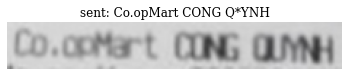

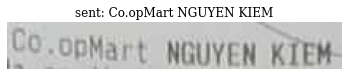

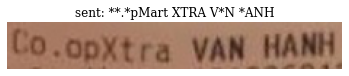

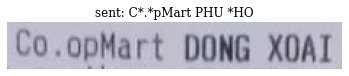

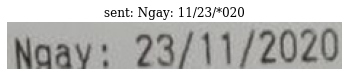

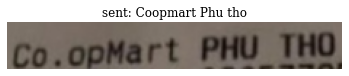

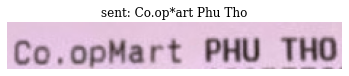

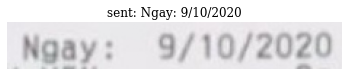

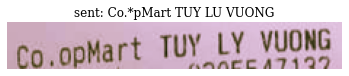

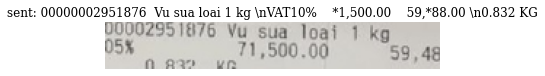

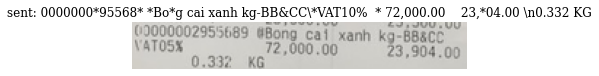

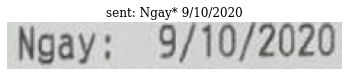

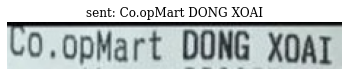

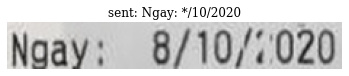

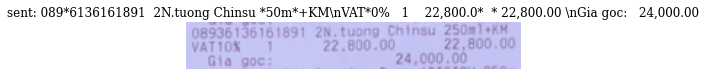

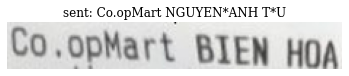

In [22]:
# sử dụng lệnh này để visualize tập train, bao gồm cả augmentation 
trainer.visualize_dataset()




In [ ]:
trainer.train()


In [ ]:
trainer.config.save(f'config_{model}.yml')


In [34]:
# import torch

In [35]:
# torch.save(trainer.model.state_dict(), f'weights/{model}_10k_finetuned.pth')


In [ ]:
trainer.visualize_prediction()


In [45]:
trainer.precision()

(0.53125, 0.82961214)

# Inference

In [48]:
# config = Cfg.load_config_from_name('vgg_transformer')
# config = Cfg.load_config_from_file(f'config_{model}.yml')

In [30]:
config = Cfg.load_config_from_name('vgg_seq2seq')

ckpt = 'weights/vgg_seq2seq.pth'

config['weights'] = ckpt
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'

config['cnn']['pretrained'] = True
config['device'] = 'cuda:0'
config['predictor']['beamsearch'] = False


In [31]:
detector = Predictor(config)


In [32]:
with open('datasets/OCR/test_annotation.txt', 'r') as f:
    lines = f.readlines()
    test_files = [line.strip().split('\t') for line in lines]


In [33]:
y_test = [t[1] for t in test_files]
y_test[0]

'08935015510737 Duong KT/mia cao cap BH50\\nVAT10%   1    9,600.00    9,600.00 \\nGia goc:   10,500.00'

In [34]:
import jiwer


In [35]:
ground_truth = y_test[0].replace('\\n', '\n')

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
]) 

transformation(ground_truth)

'08935015510737 duong ktmia cao cap bh50 vat10 1 960000 960000 gia goc 1050000'

In [36]:
partitions = ['images', 'label_text_16012020']


In [37]:
y_true = {key: [] for key in partitions}
y_pred = {key: [] for key in partitions}

for test_file in test_files:
    for partition in partitions:
        if test_file[0].startswith(partition):

            img_path = os.path.join('datasets/OCR', test_file[0])
            img = Image.open(img_path)

            s = detector.predict(img)
            y_pred[partition].append(s)
            y_true[partition].append(test_file[1])

In [38]:
results = []
for partition in partitions:
    print(partition)
    results.append(jiwer.wer(
            y_true[partition], 
            y_pred[partition], 
            truth_transform=transformation, 
            hypothesis_transform=transformation)
         )
results.append(2*((results[0]*results[1])/(results[0]+results[1]))) 

images
label_text_16012020


In [39]:
results = list(map(lambda x: str(round(x, 4)), results))

In [40]:
def get_file_name(path):
    base_dir = os.path.dirname(path)
    file_name, ext = os.path.splitext(os.path.basename(path))
    return (base_dir, file_name, ext)

base_dir, file_name, ext = get_file_name(ckpt)

dst_ckpt = os.path.join(base_dir, file_name + '_' + '_'.join(results) + ext)
os.rename(ckpt, dst_ckpt)

## Visualization

In [41]:
n_samples = 16

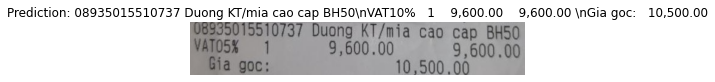

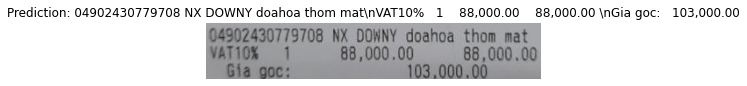

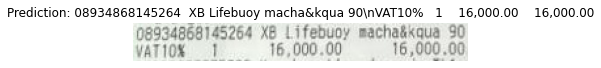

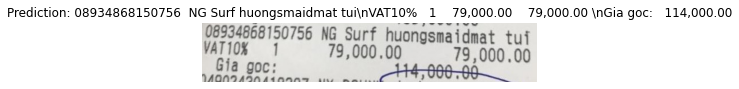

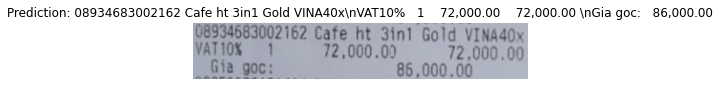

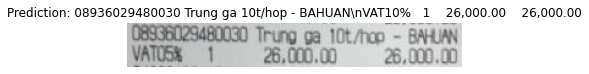

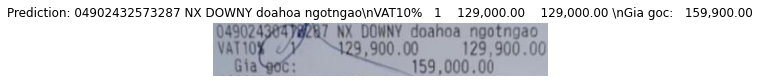

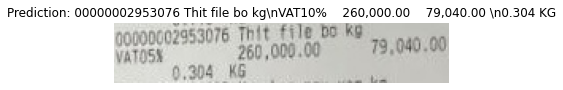

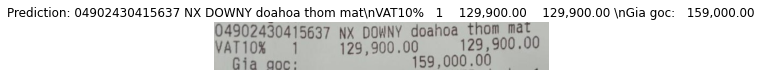

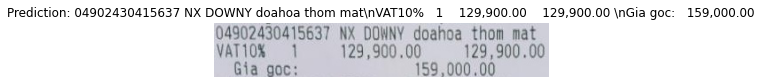

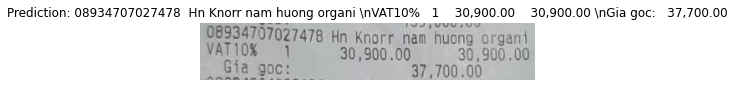

In [42]:
for i, test_file in enumerate(test_files):

    img_path = test_file[0]
    if img_path[:19] == 'label_text_16012020':
        img_path = os.path.join('datasets/OCR', img_path)
        img = Image.open(img_path)

        s = detector.predict(img)
        plt.figure()
        plt.title('Prediction: {}'.format(s), loc='center')
        plt.imshow(img)
        plt.axis('off')
    if i > n_samples:
        break
plt.show()

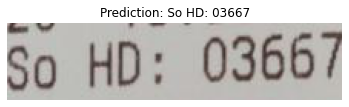

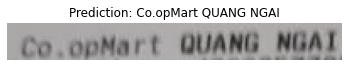

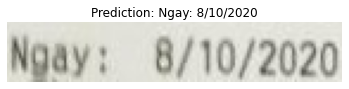

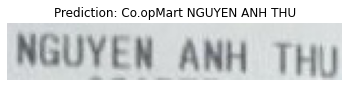

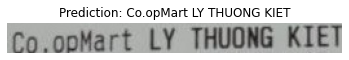

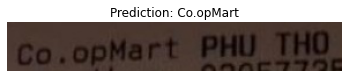

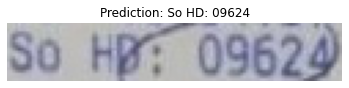

In [43]:
for i, test_file in enumerate(test_files):

    img_path = test_file[0]
    partition = 'images'
    if img_path[:len(partition)] == partition:
        img_path = os.path.join('datasets/OCR', img_path)
        img = Image.open(img_path)

        s = detector.predict(img)
        plt.figure()
        plt.title('Prediction: {}'.format(s), loc='center')
        plt.imshow(img)
        plt.axis('off')
    if i > n_samples:
        break
plt.show()